In [ ]:
import os
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional
from sklearn.metrics import roc_curve, auc

In [2]:
class Reader(object):
    def __init__(self, dataset_dir, listfile=None):
        self._dataset_dir = dataset_dir
        self._current_index = 0
        if listfile is None:
            listfile_path = os.path.join(dataset_dir, "listfile.csv")
        else:
            listfile_path = listfile
        with open(listfile_path, "r") as lfile:
            self._data = lfile.readlines()
        self._listfile_header = self._data[0]
        self._data = self._data[1:]

    def get_number_of_examples(self):
        return len(self._data)

    def random_shuffle(self, seed=None):
        if seed is not None:
            random.seed(seed)
        random.shuffle(self._data)

    def read_example(self, index):
        raise NotImplementedError()

    def read_next(self):
        to_read_index = self._current_index
        self._current_index += 1
        if self._current_index == self.get_number_of_examples():
            self._current_index = 0
        return self.read_example(to_read_index)

In [3]:
class InHospitalMortalityReader(Reader):
    def __init__(self, dataset_dir, listfile=None, period_length=48.0):
        """ Reader for in-hospital moratality prediction task.

        :param dataset_dir:   Directory where timeseries files are stored.
        :param listfile:      Path to a listfile. If this parameter is left `None` then
                              `dataset_dir/listfile.csv` will be used.
        :param period_length: Length of the period (in hours) from which the prediction is done.
        """
        Reader.__init__(self, dataset_dir, listfile)
        self._data = [line.split(',') for line in self._data]
        self._data = [(x, int(y)) for (x, y) in self._data]
        self._period_length = period_length

    def _read_timeseries(self, ts_filename):
        ret = []
        with open(os.path.join(self._dataset_dir, ts_filename), "r") as tsfile:
            header = tsfile.readline().strip().split(',')
            assert header[0] == "Hours"
            for line in tsfile:
                mas = line.strip().split(',')
                ret.append(np.array(mas))
        return (np.stack(ret), header)

    def read_example(self, index):
        """ Reads the example with given index.

        :param index: Index of the line of the listfile to read (counting starts from 0).
        :return: Dictionary with the following keys:
            X : np.array
                2D array containing all events. Each row corresponds to a moment.
                First column is the time and other columns correspond to different
                variables.
            t : float
                Length of the data in hours. Note, in general, it is not equal to the
                timestamp of last event.
            y : int (0 or 1)
                In-hospital mortality.
            header : array of strings
                Names of the columns. The ordering of the columns is always the same.
            name: Name of the sample.
        """
        if index < 0 or index >= len(self._data):
            raise ValueError("Index must be from 0 (inclusive) to number of lines (exclusive).")

        name = self._data[index][0]
        t = self._period_length
        y = self._data[index][1]
        (X, header) = self._read_timeseries(name)

        return {"X": X,
                "t": t,
                "y": y,
                "header": header,
                "name": name}


In [4]:
dataset_dir = "C:\\Users\\samit\\OneDrive\\Desktop\\Datasets\\data\\in-hospital-mortality"
root_dir = r'C:\Users\samit\OneDrive\Desktop\Datasets\data\root'

In [5]:
train_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                         listfile=os.path.join(dataset_dir, 'train_listfile.csv'),
                                         period_length=48.0)


val_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                       listfile=os.path.join(dataset_dir, 'val_listfile.csv'),
                                       period_length=48.0)

test_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'test'),
                                       listfile=os.path.join(dataset_dir, 'test_listfile.csv'),
                                       period_length=48.0)

C:\Users\samit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


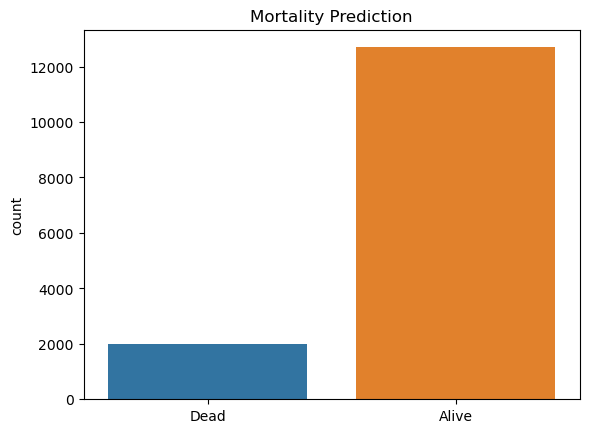

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize counters for dead and alive
dead_count = 0
alive_count = 0

# Get the total number of examples
total_examples = train_reader.get_number_of_examples()

# Loop through all the examples
for i in range(total_examples):
    example = train_reader.read_example(i)
    if example['y'] == 1:
        dead_count += 1
    elif example['y'] == 0:
        alive_count += 1

# Prepare data for plotting
data = ['Dead'] * dead_count + ['Alive'] * alive_count

# Plot using seaborn's countplot
sns.countplot(data)
plt.title('Mortality Prediction')
plt.show()


In [5]:
print(train_reader.read_example(0))

{'X': array([['0.06666666666666667', '', '60.0', ..., '', '', ''],
       ['0.15', '', '73.0', ..., '', '', ''],
       ['0.23333333333333334', '', '81.0', ..., '', '', ''],
       ...,
       ['45.233333333333334', '', '48.0', ..., '38.79999923706055', '',
        ''],
       ['46.233333333333334', '', '46.0', ..., '39.0', '', ''],
       ['47.233333333333334', '', '43.0', ..., '39.099998474121094', '',
        '']], dtype='<U19'), 't': 48.0, 'y': 1, 'header': ['Hours', 'Capillary refill rate', 'Diastolic blood pressure', 'Fraction inspired oxygen', 'Glascow coma scale eye opening', 'Glascow coma scale motor response', 'Glascow coma scale total', 'Glascow coma scale verbal response', 'Glucose', 'Heart Rate', 'Height', 'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate', 'Systolic blood pressure', 'Temperature', 'Weight', 'pH'], 'name': '25879_episode2_timeseries.csv'}


In [6]:
(train_reader.read_example(0)["X"])[1]

array(['0.15', '', '73.0', '', '', '', '', '', '', '128', '', '93',
       '100.0', '25', '133.0', '', '', ''], dtype='<U19')

In [7]:
import numpy as np

def discretize(data, timestep=0.8, impute_strategy='previous', start_time='zero'):
    """
    Discretizes the time series data into fixed timesteps and fills missing values.
    """
    # Sort data by time
    data = sorted(data, key=lambda x: float(x[0]))

    # Create an array for discretized data
    discretized_data = []

    # Fill missing values
    prev_values = None
    for i in range(len(data)):
        if i == 0 and start_time == 'zero':
            row = ['0.0'] + list(data[i][1:])  # Change 0 to '0.0' to match the data type
        else:
            row = list(data[i])

        if impute_strategy == 'previous':
            if prev_values is not None:
                row = [(row[j] if row[j] != '' else prev_values[j]) for j in range(len(row))]
            prev_values = row

        discretized_data.append(row)

    # Transform into fixed timestep format
    time_intervals = np.arange(0, max([float(row[0]) for row in discretized_data]) + timestep, timestep)
    fixed_timestep_data = []
    for t in time_intervals:
        fixed_timestep_data.append([str(t)] + [row[1:] for row in discretized_data if float(row[0]) <= t][-1])

    # Handle missing values (replace empty strings and non-numeric values with '0.0')
    #fixed_timestep_data = [[('0.0' if (cell == '' or not cell.replace('.', '', 1).isdigit()) else cell) for cell in row] for row in fixed_timestep_data]

    # Convert to numerical format and handle missing values
    
    # One-hot encode categorical variables
    # One-hot encode categorical variables
#     for i, channel in enumerate(CHANNELS.keys()):
#         if CHANNELS[channel] == 'categorical':
#             category_mapping = global_category_mapping[channel]
#             one_hot_encoded = np.zeros((len(fixed_timestep_data), len(category_mapping)))
#             for j, category in enumerate(category_mapping.keys()):
#                 one_hot_encoded[np.array(fixed_timestep_data)[:, i+1] == category, category_mapping[category]] = 1
#             fixed_timestep_data = np.column_stack((fixed_timestep_data, one_hot_encoded))
#             fixed_timestep_data = np.delete(fixed_timestep_data, i+1, axis=1)
    for i, channel in enumerate(CHANNELS.keys()):
        if CHANNELS[channel] == 'categorical':
            category_mapping = global_category_mapping[channel]
            fixed_timestep_data_array = np.array(fixed_timestep_data)
            for category, mapped_value in category_mapping.items():
                fixed_timestep_data_array[fixed_timestep_data_array[:, i+1] == category, i+1] = mapped_value
            fixed_timestep_data = fixed_timestep_data_array.tolist()



            
    fixed_timestep_data = [[('0.0' if (cell == '' or not cell.replace('.', '', 1).isdigit()) else cell) for cell in row] for row in fixed_timestep_data]

    df = pd.DataFrame(fixed_timestep_data, columns=['Time'] + ['Var' + str(i) for i in range(1, len(fixed_timestep_data[0]))])
    df = df.replace('', np.nan)
    df = df.fillna(method='ffill')
    df = df.fillna(0)  # Fill any remaining missing values with 0

    # Convert back to numpy array
    numerical_data = df.values.astype(np.float32)
#     numerical_data = np.array(fixed_timestep_data, dtype=np.float32)
#     numerical_data[np.isnan(numerical_data)] = 0


    return numerical_data








In [8]:
from sklearn.preprocessing import StandardScaler

def normalize(data):
    """
    Normalizes the data by scaling the continuous features to have a mean of 0 and a standard deviation of 1.
    """
    channels = CHANNELS
    # Separate time and features
    time = data[:, 0]
    features = data[:, 1:]

    # Identify the indices of the continuous and categorical features
    continuous_indices = [i for i, channel in enumerate(channels.keys()) if channels[channel] == 'numerical']
    categorical_indices = [i for i, channel in enumerate(channels.keys()) if channels[channel] == 'categorical']

    # Separate continuous and categorical features
    continuous_features = features[:, continuous_indices]
    categorical_features = features[:, categorical_indices]

    # Standardize the continuous features
    scaler = StandardScaler()
    standardized_continuous_features = scaler.fit_transform(continuous_features)

    # Create an empty array to hold the standardized features
    standardized_features = np.empty(features.shape, dtype=features.dtype)

    # Put the standardized continuous features back into their original positions
    for i, index in enumerate(continuous_indices):
        standardized_features[:, index] = standardized_continuous_features[:, i]

    # Put the transformed categorical features back into their original positions
    for i, index in enumerate(categorical_indices):
        standardized_features[:, index] = categorical_features[:, i]

    # Concatenate time and standardized features
    normalized_data = np.column_stack((time, standardized_features))

    return normalized_data






In [9]:
def pad_zeros(arr, min_length=None):
    """
    `arr` is an array of `np.array`s

    The function appends zeros to every `np.array` in `arr`
    to equalize their first axis lenghts.
    """
    dtype = arr[0].dtype
    max_len = max([x.shape[0] for x in arr])
    ret = [np.concatenate([x, np.zeros((max_len - x.shape[0],) + x.shape[1:], dtype=dtype)], axis=0)
           for x in arr]
    if (min_length is not None) and ret[0].shape[0] < min_length:
        ret = [np.concatenate([x, np.zeros((min_length - x.shape[0],) + x.shape[1:], dtype=dtype)], axis=0)
               for x in ret]
    return np.array(ret)

In [10]:
CHANNELS = {
    'Capillary refill rate': 'categorical',
    'Diastolic blood pressure': 'numerical',
    'Fraction inspired oxygen': 'numerical',
    'Glascow coma scale eye opening': 'categorical',
    'Glascow coma scale motor response': 'categorical',
    'Glascow coma scale total': 'numerical',
    'Glascow coma scale verbal response': 'categorical',
    'Glucose': 'numerical',
    'Heart Rate': 'numerical',
    'Height': 'numerical',
    'Mean blood pressure': 'numerical',
    'Oxygen saturation': 'numerical',
    'Respiratory rate': 'numerical',
    'Systolic blood pressure': 'numerical',
    'Temperature': 'numerical',
    'Weight': 'numerical',
    'pH':'numerical'
}
# CHANNELS = {
#     'Diastolic blood pressure': 'numerical',
#     'Fraction inspired oxygen': 'numerical',
#     'Glascow coma scale eye opening': 'categorical',
#     'Glascow coma scale motor response': 'categorical',
#     'Glascow coma scale total': 'numerical',
#     'Glascow coma scale verbal response': 'categorical',
#     'Glucose': 'numerical',
#     'Heart Rate': 'numerical',
#     'Mean blood pressure': 'numerical',
#     'Oxygen saturation': 'numerical',
#     'Respiratory rate': 'numerical',
#     'Systolic blood pressure': 'numerical',
#     'Temperature': 'numerical',
#     'Weight': 'numerical'
# }

In [11]:
from collections import defaultdict

# Initialize a dictionary to store the unique categories for each categorical variable
unique_categories = defaultdict(set)

# Load the time series data for all patients
for i in range(train_reader.get_number_of_examples()):
    data = train_reader.read_example(i)
    for channel, dtype in CHANNELS.items():
        if dtype == 'categorical':
            index = data['header'].index(channel)
            categories = set(data['X'][:, index])
            unique_categories[channel].update(categories)

# Create a global mapping of categories to indices for each categorical variable
global_category_mapping = {}
for channel, categories in unique_categories.items():
    global_category_mapping[channel] = {category: i for i, category in enumerate(categories)}

In [12]:
global_category_mapping

{'Capillary refill rate': {'': 0, '1.0': 1, '0.0': 2},
 'Glascow coma scale eye opening': {'': 0,
  '3 To speech': 1,
  'To Pain': 2,
  '1 No Response': 3,
  '4 Spontaneously': 4,
  'To Speech': 5,
  '2 To pain': 6,
  'Spontaneously': 7,
  'None': 8},
 'Glascow coma scale motor response': {'': 0,
  '3 Abnorm flexion': 1,
  '4 Flex-withdraws': 2,
  'Obeys Commands': 3,
  '1 No Response': 4,
  '5 Localizes Pain': 5,
  'No response': 6,
  '6 Obeys Commands': 7,
  'Abnormal Flexion': 8,
  'Abnormal extension': 9,
  'Localizes Pain': 10,
  'Flex-withdraws': 11,
  '2 Abnorm extensn': 12},
 'Glascow coma scale verbal response': {'': 0,
  '1.0 ET/Trach': 1,
  'Inappropriate Words': 2,
  '3 Inapprop words': 3,
  '1 No Response': 4,
  '5 Oriented': 5,
  'Oriented': 6,
  'No Response': 7,
  'No Response-ETT': 8,
  'Incomprehensible sounds': 9,
  '4 Confused': 10,
  'Confused': 11,
  '2 Incomp sounds': 12}}

In [13]:
# Define the mappings for the categorical columns
admission_mapping = {'UNKNOWN': 0, 'EMERGENCY': 1, 'ELECTIVE': 2, 'URGENT': 3}
dbsource_mapping = {'carevue': 1, 'metavision': 2, 'both': 3}
icu_unit_mapping = {'MICU': 1, 'CCU': 2, 'TSICU': 3, 'SICU': 4, 'CSRU': 5}

def get_static_features(reader, index, root):
    # Read the example from the reader
    example = reader.read_example(index)
    
    # Extract the patient ID and episode number from the file name
    file_name = example['name']
    patient_id, episode_num = file_name.split('_')[0], file_name.split('_')[1].replace('episode', '')
    
    # Define the root directory and train folder
    if root == 'train':
        train_dir = os.path.join(root_dir, 'train')
    elif root == 'test':
        train_dir = os.path.join(root_dir, 'test')
    
    # Load the combined data
    combined_data = pd.read_csv('combined_data')
    
    # Access the patient folder
    patient_path = os.path.join(train_dir, patient_id)
    
    # Load the stays data
    stays_data = pd.read_csv(os.path.join(patient_path, 'stays.csv'))
    
    # Access the episode folder
    #episode_path = os.path.join(patient_path, f'episode{episode_num}')
    
    # Load the episode data
    episode_data = pd.read_csv(os.path.join(patient_path, f'episode{episode_num}.csv'))
    
    # Extract the relevant features
    age = episode_data['Age'].values[0]
    height = episode_data['Height'].values[0]
    weight = episode_data['Weight'].values[0]
    ethnicity = episode_data['Ethnicity'].values[0]
    gender = episode_data['Gender'].values[0]
    dbsource = stays_data['DBSOURCE'].values[0]
    last_careunit = stays_data['LAST_CAREUNIT'].values[0]
    
    # Get the admission type from the combined data
    # Get the admission type from the combined data
    icustay_id = stays_data['ICUSTAY_ID'].values[0]
    matching_rows = combined_data[combined_data['ICUSTAY_ID'] == icustay_id]

    if not matching_rows.empty:
        admission_type = matching_rows['ADMISSION_TYPE'].values[0]
    else:
        # Handle the case where there are no matching rows
        print(f"No matching rows found for ICUSTAY_ID {icustay_id}")
        admission_type = "UNKNOWN"

    
    # Create the static data vector
    static_data_vector = [age, height, weight, gender,ethnicity, dbsource, last_careunit, admission_type]
#     static_data_df = pd.DataFrame(static_data_vectors, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
#     # Apply the mappings to the static data DataFrame
#     static_data_df['AdmissionType'] = static_data_df['AdmissionType'].map(admission_mapping)
#     static_data_df['DBSource'] = static_data_df['DBSource'].map(dbsource_mapping)
#     static_data_df['LastCareUnit'] = static_data_df['LastCareUnit'].map(icu_unit_mapping)
#     static_data_vector = static_data_df.loc[0, :].values.tolist()

    return static_data_vector

In [14]:
# Process training data
from keras.utils import to_categorical
train_data_timeseries = []
train_data_static = []
train_labels = []
#drop_features = ['Height', 'Capillary refill rate']

for i in range(train_reader.get_number_of_examples()):
    example = train_reader.read_example(i)
    #     drop_indices = [example['header'].index(feature) for feature in drop_features]
    #     data = np.array(example['X'], dtype='<U20')
    #     data = np.delete(data, drop_indices, axis=1)
    #     example['X'] = data
    #     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector = get_static_features(train_reader, i,'train')
    for j in range(len(static_data_vector)):
        if isinstance(static_data_vector[j], (int, float)):
            static_data_vector[j] = float(static_data_vector[j])
        # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array = np.array(static_data_vector,dtype=object)
    #static_data_array = np.repeat(np.array(static_data_vector)[np.newaxis, :], normalized_data.shape[0], axis=0)

    # Concatenate the static data array with the time series data
    #concatenated_data = np.concatenate((normalized_data, static_data_array), axis=1)

    train_data_timeseries.append(normalized_data)
    train_data_static.append(static_data_array)
    train_labels.append(example['y'])
padded_train_data = pad_zeros(train_data_timeseries)
static_data_df = pd.DataFrame(train_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_df['AdmissionType'] = static_data_df['AdmissionType'].map(admission_mapping)
static_data_df['DBSource'] = static_data_df['DBSource'].map(dbsource_mapping)
static_data_df['LastCareUnit'] = static_data_df['LastCareUnit'].map(icu_unit_mapping)
numerical_features = ['Age', 'Height', 'Weight']
# Standardize the numerical features
scaler = StandardScaler()
scaler.fit(static_data_df[numerical_features])
static_data_df[numerical_features] = scaler.transform(static_data_df[numerical_features])
train_data_static = static_data_df.to_numpy()

#padded_train_data = np.concatenate(padded_train_data, axis=0)
#train_labels = to_categorical(train_labels)

# Process validation data
val_data_timeseries = []
val_data_static = []
val_labels = []
for i in range(val_reader.get_number_of_examples()):
    example = val_reader.read_example(i)
#     drop_indices = [example['header'].index(feature) for feature in drop_features]
#     data = np.array(example['X'], dtype='<U20')
#     data = np.delete(data, drop_indices, axis=1)
#     example['X'] = data
#     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector_val = get_static_features(val_reader, i,'train')
    for j in range(len(static_data_vector_val)):
        if isinstance(static_data_vector_val[j], (int, float)):
            static_data_vector_val[j] = float(static_data_vector_val[j])

    # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array_val = np.array(static_data_vector_val, dtype=object)

    val_data_timeseries.append(normalized_data)
    val_data_static.append(static_data_array_val)
    val_labels.append(example['y'])
padded_val_data = pad_zeros(val_data_timeseries)
static_data_val_df = pd.DataFrame(val_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_val_df['AdmissionType'] = static_data_val_df['AdmissionType'].map(admission_mapping)
static_data_val_df['DBSource'] = static_data_val_df['DBSource'].map(dbsource_mapping)
static_data_val_df['LastCareUnit'] = static_data_val_df['LastCareUnit'].map(icu_unit_mapping)
static_data_val_df[numerical_features] = scaler.transform(static_data_val_df[numerical_features])
val_data_static = static_data_val_df.to_numpy()
#padded_val_data = np.concatenate(padded_val_data, axis=0)
#val_labels = to_categorical(val_labels)


No matching rows found for ICUSTAY_ID 283217


In [15]:
test_data_timeseries = []
test_data_static = []
test_labels = []
for i in range(test_reader.get_number_of_examples()):
    example = test_reader.read_example(i)
#     drop_indices = [example['header'].index(feature) for feature in drop_features]
#     data = np.array(example['X'], dtype='<U20')
#     data = np.delete(data, drop_indices, axis=1)
#     example['X'] = data
#     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector_test = get_static_features(test_reader, i,'test')
    for j in range(len(static_data_vector_test)):
        if isinstance(static_data_vector_test[j], (int, float)):
            static_data_vector_test[j] = float(static_data_vector_test[j])

    # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array_test = np.array(static_data_vector_test, dtype=object)

    test_data_timeseries.append(normalized_data)
    test_data_static.append(static_data_array_test)
    test_labels.append(example['y'])
padded_test_data = pad_zeros(test_data_timeseries)
static_data_test_df = pd.DataFrame(test_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_test_df['AdmissionType'] = static_data_test_df['AdmissionType'].map(admission_mapping)
static_data_test_df['DBSource'] = static_data_test_df['DBSource'].map(dbsource_mapping)
static_data_test_df['LastCareUnit'] = static_data_test_df['LastCareUnit'].map(icu_unit_mapping)
static_data_test_df[numerical_features] = scaler.transform(static_data_test_df[numerical_features])
test_data_static = static_data_test_df.to_numpy()

In [16]:
test_data_static

array([[-0.72439295,         nan, -0.95239509, ...,  1.        ,
         1.        ,  1.        ],
       [ 4.07634932,         nan, -0.67542541, ...,  1.        ,
         4.        ,  1.        ],
       [ 0.02334562,         nan, -0.42538337, ...,  1.        ,
         2.        ,  3.        ],
       ...,
       [-0.60606243,  0.9906259 ,  1.46724253, ...,  2.        ,
         4.        ,  1.        ],
       [-0.03847865, -0.23973868, -0.80768941, ...,  2.        ,
         2.        ,  1.        ],
       [ 0.19942638, -0.92327457, -0.8254507 , ...,  2.        ,
         1.        ,  1.        ]])

In [17]:
padded_val_data.shape

(3222, 61, 18)

In [18]:
import numpy as np

# Calculate the number of nan values in each column of padded_train_data
nan_counts_padded = np.isnan(padded_train_data).sum(axis=0)

# Calculate the total number of values in each column of padded_train_data
total_counts_padded = padded_train_data.shape[0]

# Calculate the percentage of nan values in each column of padded_train_data
nan_percentage_padded = (nan_counts_padded / total_counts_padded) * 100

# Calculate the number of nan values in each column of train_static_data
nan_counts_static = np.isnan(train_data_static_new).sum(axis=0)

# Calculate the total number of values in each column of train_static_data
total_counts_static = train_data_static_new.shape[0]

# Calculate the percentage of nan values in each column of train_static_data
nan_percentage_static = (nan_counts_static / total_counts_static) * 100

print("Percentage of nan values in each column of padded_train_data:", nan_percentage_padded)
print("Percentage of nan values in each column of train_static_data:", nan_percentage_static)



NameError: name 'train_data_static_new' is not defined

In [27]:
for i in range(padded_train_data.shape[0]):
    for j in range(padded_train_data.shape[1]):
        dataset = padded_train_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_train_data[i, j, :] = dataset

In [28]:
# Do the same for the validation data
for i in range(padded_val_data.shape[0]):
    for j in range(padded_val_data.shape[1]):
        dataset = padded_val_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_val_data[i, j, :] = dataset

In [29]:
for i in range(padded_test_data.shape[0]):
    for j in range(padded_test_data.shape[1]):
        dataset = padded_test_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_test_data[i, j, :] = dataset

In [30]:
import numpy as np

# Assuming val_data_static is a numpy array
column_index_to_drop = 1  # Index of the column with 74.45% nan values
train_data_static_new = np.delete(train_data_static, column_index_to_drop, axis=1)
val_data_static_new = np.delete(val_data_static, column_index_to_drop, axis=1)

In [31]:
column_index_to_drop = 1
test_data_static = np.delete(test_data_static,column_index_to_drop, axis=1 ) 

In [32]:
import numpy as np

# Assuming train_static_data and val_static_data are your static data arrays
# Assuming the weight column is the second column (index 1)

# Calculate the mean of the non-missing values in the weight column of the training data
mean_weight_train = np.nanmean(train_data_static_new[:, 1])

# Impute the missing values in the weight column of the training data with the mean
train_data_static_new[:, 1] = np.where(np.isnan(train_data_static_new[:, 1]), mean_weight_train, train_data_static_new[:, 1])

# Impute the missing values in the weight column of the validation data with the mean from the training data
val_data_static_new[:, 1] = np.where(np.isnan(val_data_static_new[:, 1]), mean_weight_train, val_data_static_new[:, 1])


In [33]:
test_data_static[:, 1] = np.where(np.isnan(test_data_static[:, 1]), mean_weight_train, test_data_static[:, 1])

In [34]:
train_data_static = train_data_static_new
val_data_static = val_data_static_new 

In [35]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the LSTM layers for the time series data
lstm_layer = LSTM(64, return_sequences=True)(time_series_input)
lstm_layer = LSTM(32)(lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([lstm_layer, static_input])

# Define the dense layers
# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.5
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, None, 64)     21248       ['input_3[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  (None, 32)           12416       ['lstm_2[0][0]']                 
                                                                                                  
 input_4 (InputLayer)           [(None, 6)]          0           []                               
                                                                                            

In [36]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [37]:
# Convert the labels to NumPy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Fit the model
history = model.fit(
    [padded_train_data, train_data_static], train_labels,
    validation_data=([padded_val_data, val_data_static], val_labels),
    epochs=20,
    batch_size=32
)

Epoch 1/20
459/459 [==============================] - 27s 49ms/step - loss: 0.3937 - accuracy: 0.8638 - val_loss: 0.3621 - val_accuracy: 0.8647
Epoch 2/20
459/459 [==============================] - 23s 51ms/step - loss: 0.3618 - accuracy: 0.8647 - val_loss: 0.3365 - val_accuracy: 0.8647
Epoch 3/20
459/459 [==============================] - 21s 46ms/step - loss: 0.3466 - accuracy: 0.8647 - val_loss: 0.3315 - val_accuracy: 0.8647
Epoch 4/20
459/459 [==============================] - 23s 50ms/step - loss: 0.3368 - accuracy: 0.8672 - val_loss: 0.3278 - val_accuracy: 0.8641
Epoch 5/20
459/459 [==============================] - 23s 51ms/step - loss: 0.3350 - accuracy: 0.8650 - val_loss: 0.3342 - val_accuracy: 0.8656
Epoch 6/20
459/459 [==============================] - 23s 50ms/step - loss: 0.3322 - accuracy: 0.8667 - val_loss: 0.3228 - val_accuracy: 0.8659
Epoch 7/20
459/459 [==============================] - 24s 52ms/step - loss: 0.3266 - accuracy: 0.8685 - val_loss: 0.3216 - val_accuracy:

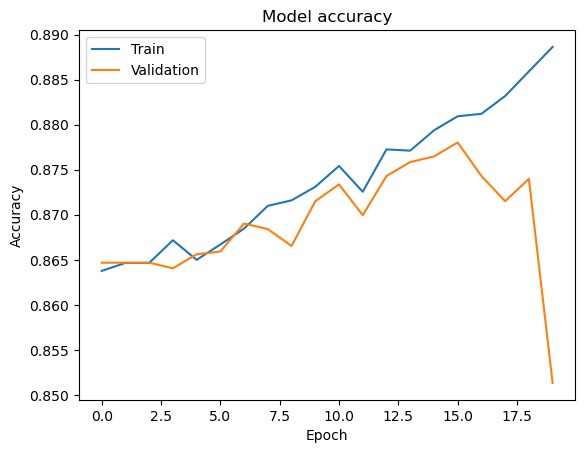

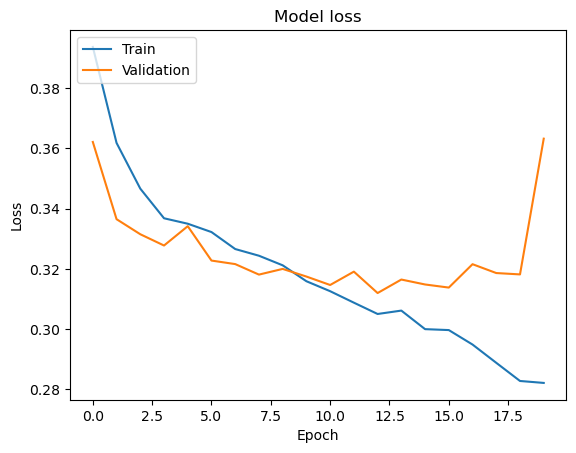

In [38]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict the probabilities of the test data
y_pred_probs = model.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


102/102 [==============================] - 3s 18ms/step
AUC-ROC Score: 0.7950911258347441
Accuracy: 0.8686650185414091
Precision: 0.42735042735042733
Recall: 0.40106951871657753
F1 Score: 0.41379310344827586


In [40]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the Bidirectional LSTM layers for the time series data
bi_lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(time_series_input)
bi_lstm_layer = Bidirectional(LSTM(32))(bi_lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([bi_lstm_layer, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.5
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model1 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model1.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 128)    42496       ['input_5[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 64)          41216       ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 6)]          0           []                         

In [41]:
val_labels = np.array(val_labels)
history1 = model1.fit(
    [padded_train_data, train_data_static], train_labels,
    validation_data=([padded_val_data, val_data_static], val_labels),
    epochs=20,
    batch_size=32
)

Epoch 1/20
459/459 [==============================] - 32s 53ms/step - loss: 0.3885 - accuracy: 0.8645 - val_loss: 0.3515 - val_accuracy: 0.8650
Epoch 2/20
459/459 [==============================] - 23s 50ms/step - loss: 0.3551 - accuracy: 0.8645 - val_loss: 0.3395 - val_accuracy: 0.8647
Epoch 3/20
459/459 [==============================] - 23s 50ms/step - loss: 0.3434 - accuracy: 0.8653 - val_loss: 0.3315 - val_accuracy: 0.8641
Epoch 4/20
459/459 [==============================] - 23s 50ms/step - loss: 0.3322 - accuracy: 0.8681 - val_loss: 0.3220 - val_accuracy: 0.8656
Epoch 5/20
459/459 [==============================] - 23s 51ms/step - loss: 0.3282 - accuracy: 0.8694 - val_loss: 0.3341 - val_accuracy: 0.8662
Epoch 6/20
459/459 [==============================] - 23s 51ms/step - loss: 0.3213 - accuracy: 0.8705 - val_loss: 0.3228 - val_accuracy: 0.8700
Epoch 7/20
459/459 [==============================] - 23s 51ms/step - loss: 0.3168 - accuracy: 0.8730 - val_loss: 0.3171 - val_accuracy:

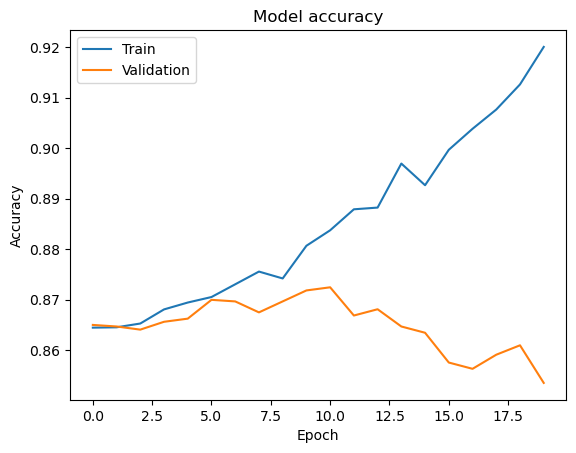

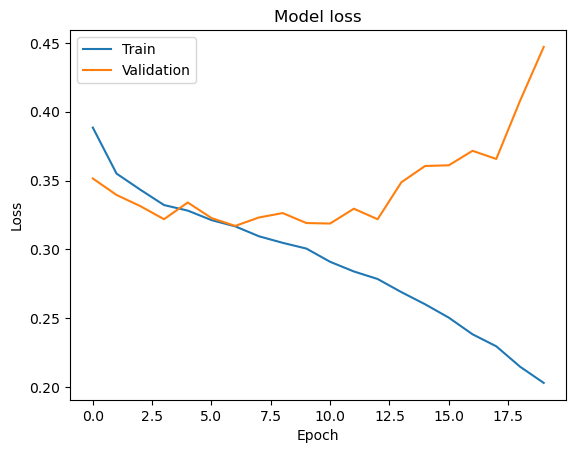

In [42]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [43]:
# Predict the probabilities of the test data
y_pred_probs = model1.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

102/102 [==============================] - 4s 19ms/step
AUC-ROC Score: 0.7631232786615694
Accuracy: 0.8686650185414091
Precision: 0.3967611336032389
Recall: 0.2620320855614973
F1 Score: 0.3156199677938808


In [44]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Create separate LSTM layers for each channel in the time series data
lstm_outputs = []
for i in range(padded_train_data.shape[2]):
    channel_input = time_series_input[:,:,i:i+1]  # Select the i-th channel from the input data
    lstm_layer = LSTM(64, return_sequences=True)(channel_input)
    lstm_layer = LSTM(32)(lstm_layer)
    lstm_outputs.append(lstm_layer)

# Concatenate the outputs of the LSTM layers
concat_lstm = Concatenate()(lstm_outputs)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([concat_lstm, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.5
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model3 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model3.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, None, 1)     0           ['input_7[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, None, 1)     0           ['input_7[0][0]']                
 icingOpLambda)                                                                                   
                                                                                            

In [45]:
history2 = model3.fit(
    [padded_train_data, train_data_static], train_labels,
    validation_data=([padded_val_data, val_data_static], val_labels),
    epochs=20,
    batch_size=32
)

Epoch 1/20
459/459 [==============================] - 178s 245ms/step - loss: 0.3745 - accuracy: 0.8648 - val_loss: 0.3401 - val_accuracy: 0.8687
Epoch 2/20
459/459 [==============================] - 99s 216ms/step - loss: 0.3512 - accuracy: 0.8652 - val_loss: 0.3399 - val_accuracy: 0.8693
Epoch 3/20
459/459 [==============================] - 97s 211ms/step - loss: 0.3400 - accuracy: 0.8664 - val_loss: 0.3295 - val_accuracy: 0.8687
Epoch 4/20
459/459 [==============================] - 97s 211ms/step - loss: 0.3347 - accuracy: 0.8650 - val_loss: 0.3249 - val_accuracy: 0.8684
Epoch 5/20
459/459 [==============================] - 97s 212ms/step - loss: 0.3344 - accuracy: 0.8662 - val_loss: 0.3230 - val_accuracy: 0.8690
Epoch 6/20
459/459 [==============================] - 98s 213ms/step - loss: 0.3317 - accuracy: 0.8676 - val_loss: 0.3200 - val_accuracy: 0.8727
Epoch 7/20
459/459 [==============================] - 98s 214ms/step - loss: 0.3265 - accuracy: 0.8673 - val_loss: 0.3209 - val_a

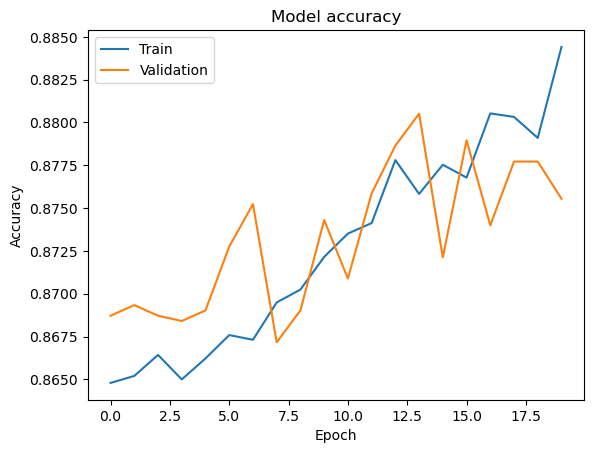

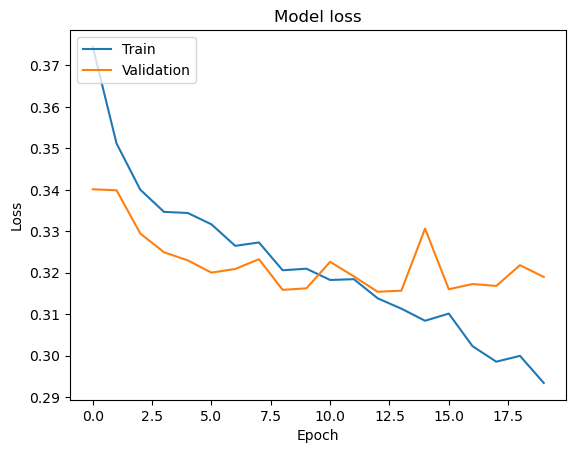

In [46]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [47]:
# Predict the probabilities of the test data
y_pred_probs = model3.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

102/102 [==============================] - 22s 81ms/step
AUC-ROC Score: 0.8032769425666206
Accuracy: 0.8881334981458591
Precision: 0.5357142857142857
Recall: 0.24064171122994651
F1 Score: 0.3321033210332104


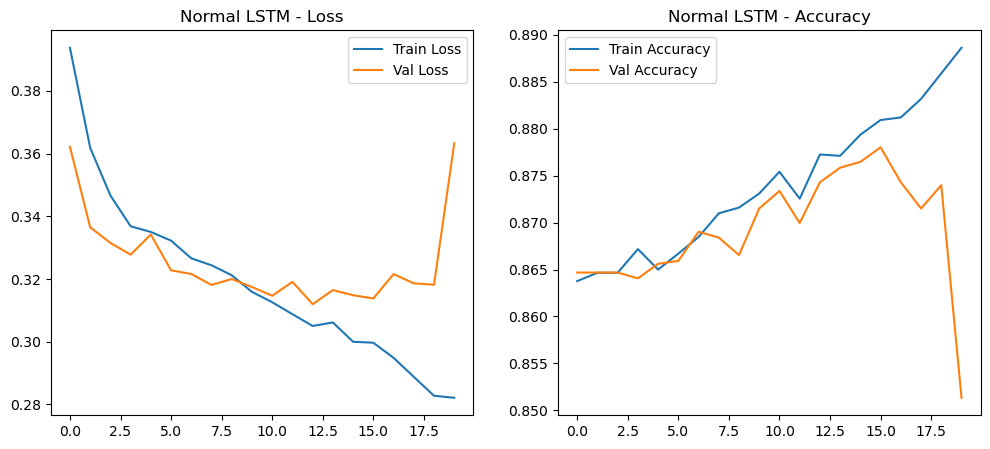

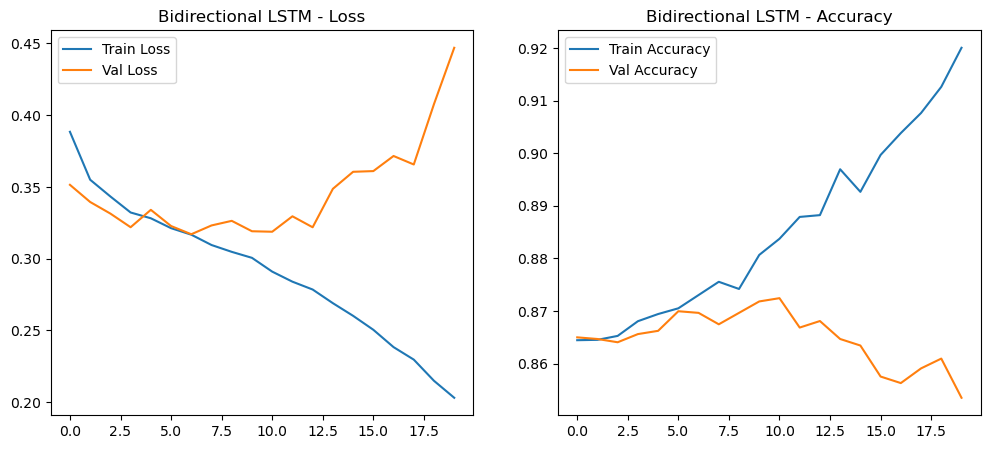

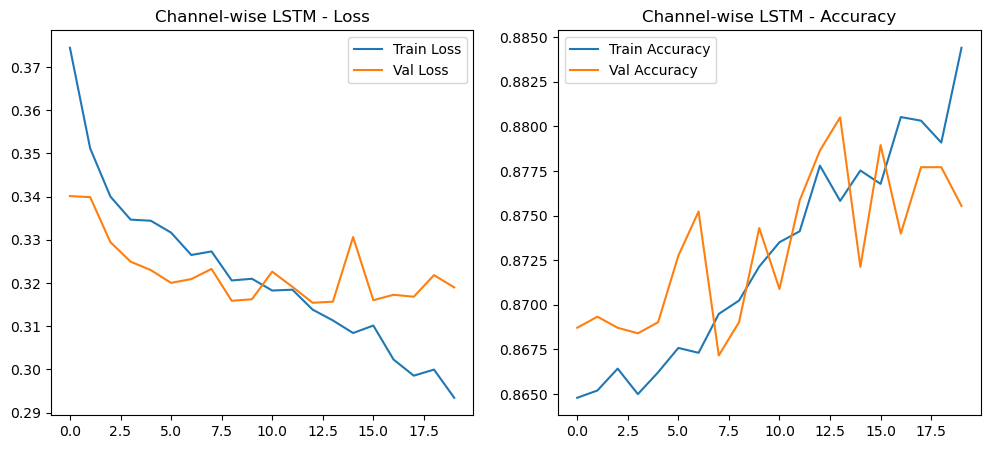

102/102 [==============================] - 2s 19ms/step


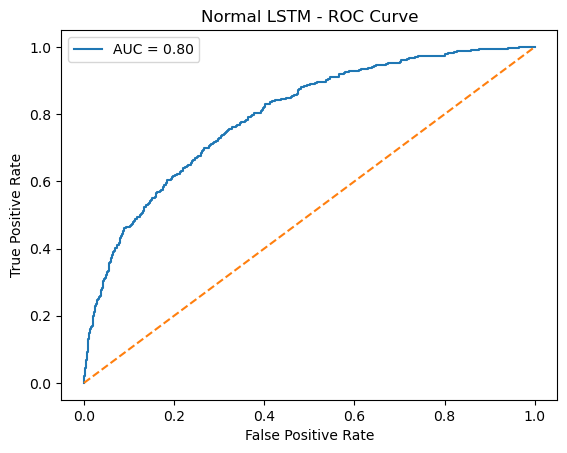

102/102 [==============================] - 2s 24ms/step


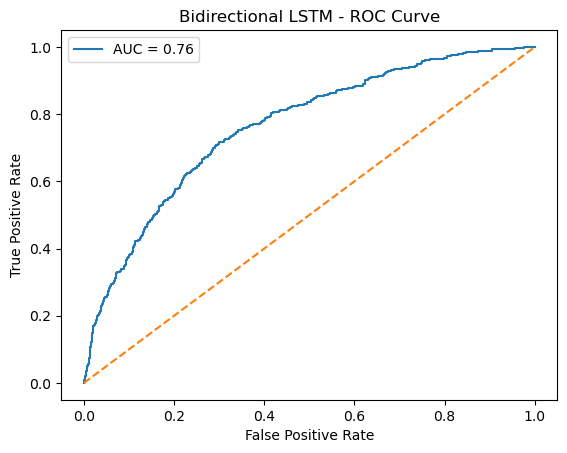

102/102 [==============================] - 8s 76ms/step


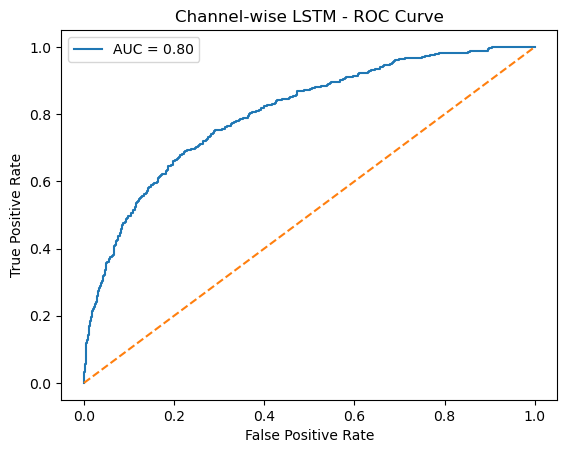

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define a function to plot the training and validation loss and accuracy
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(title + ' - Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title(title + ' - Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss and accuracy for each model
plot_history(history.history, 'Normal LSTM')
plot_history(history1.history, 'Bidirectional LSTM')
plot_history(history2.history, 'Channel-wise LSTM')

# Define a function to plot the AUC-ROC curve
def plot_roc_curve(model, X_val, y_val, title):
    y_pred = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_value))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + ' - ROC Curve')
    plt.legend()
    plt.show()

# Plot the AUC-ROC curve for each model
plot_roc_curve(model, [padded_test_data, test_data_static], test_labels, 'Normal LSTM')
plot_roc_curve(model1, [padded_test_data, test_data_static], test_labels, 'Bidirectional LSTM')
plot_roc_curve(model3, [padded_test_data, test_data_static], test_labels, 'Channel-wise LSTM')



102/102 [==============================] - 2s 17ms/step


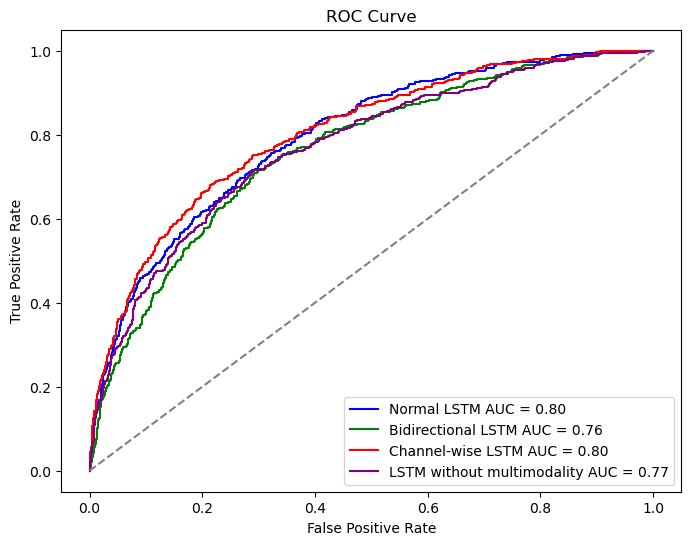

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define a function to plot the AUC-ROC curve for each model
def plot_roc_curve(model, X_val, y_val, label, color):
    y_pred = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label='{} AUC = {:.2f}'.format(label, auc_value))

# Plot the AUC-ROC curves for each model in a single plot
plt.figure(figsize=(8, 6))
plot_roc_curve(model, [padded_test_data, test_data_static], test_labels, 'Normal LSTM', 'blue')
plot_roc_curve(model1, [padded_test_data, test_data_static], test_labels, 'Bidirectional LSTM', 'green')
plot_roc_curve(model3, [padded_test_data, test_data_static], test_labels, 'Channel-wise LSTM', 'red')
plot_roc_curve(model4, padded_test_data, test_labels, 'LSTM without multimodality', 'purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [55]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# Define model parameters
input_shape = (padded_train_data.shape[1], padded_train_data.shape[2])
output_size = 1  # Binary classification (0 or 1)

# Build the LSTM model
model4 = Sequential()
model4.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model4.add(Dropout(0.3))  # Add dropout layer with 20% dropout rate
model4.add(LSTM(32))
model4.add(Dropout(0.3))  # Add dropout layer with 20% dropout rate
model4.add(Dense(output_size, activation='sigmoid'))

# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 61, 64)            21248     
                                                                 
 dropout_12 (Dropout)        (None, 61, 64)            0         
                                                                 
 lstm_47 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 33,697
Trainable params: 33,697
Non-trainable params: 0
_________________________________________________________________


In [56]:
history4 = model4.fit(padded_train_data, train_labels, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(padded_val_data, val_labels))

Epoch 1/20
459/459 [==============================] - 30s 54ms/step - loss: 0.3976 - accuracy: 0.8610 - val_loss: 0.3808 - val_accuracy: 0.8647
Epoch 2/20
459/459 [==============================] - 23s 50ms/step - loss: 0.3648 - accuracy: 0.8648 - val_loss: 0.3474 - val_accuracy: 0.8656
Epoch 3/20
459/459 [==============================] - 25s 54ms/step - loss: 0.3524 - accuracy: 0.8630 - val_loss: 0.3400 - val_accuracy: 0.8672
Epoch 4/20
459/459 [==============================] - 25s 54ms/step - loss: 0.3440 - accuracy: 0.8654 - val_loss: 0.3375 - val_accuracy: 0.8687
Epoch 5/20
459/459 [==============================] - 23s 51ms/step - loss: 0.3386 - accuracy: 0.8673 - val_loss: 0.3428 - val_accuracy: 0.8696
Epoch 6/20
459/459 [==============================] - 22s 47ms/step - loss: 0.3371 - accuracy: 0.8678 - val_loss: 0.3354 - val_accuracy: 0.8672
Epoch 7/20
459/459 [==============================] - 25s 54ms/step - loss: 0.3321 - accuracy: 0.8703 - val_loss: 0.3305 - val_accuracy:

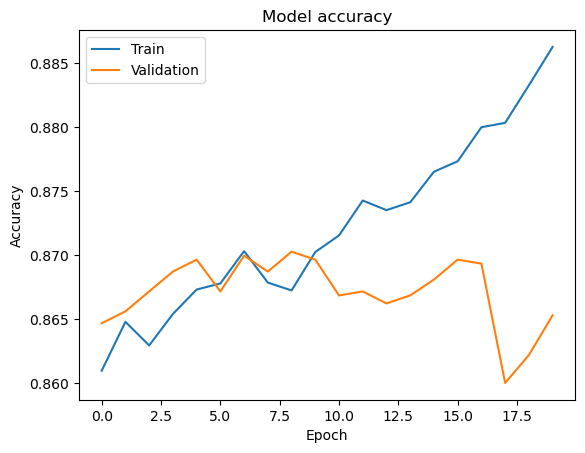

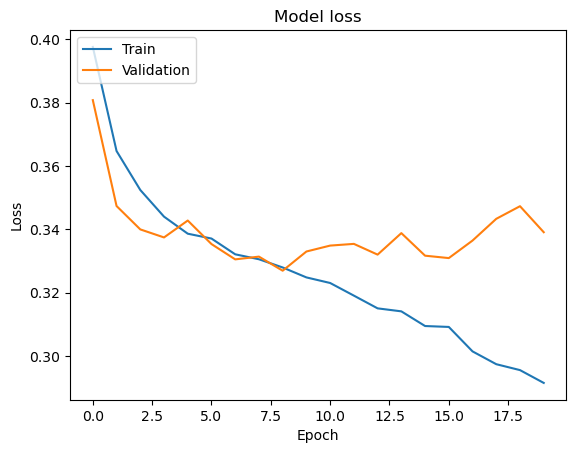

In [57]:
import matplotlib.pyplot as plt

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [59]:
# Predict the probabilities of the test data
y_pred_probs = model4.predict(padded_test_data)

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

102/102 [==============================] - 2s 16ms/step
AUC-ROC Score: 0.7707868548601067
Accuracy: 0.8850432632880099
Precision: 0.5071428571428571
Recall: 0.18983957219251338
F1 Score: 0.27626459143968873


102/102 [==============================] - 2s 18ms/step
AUC-ROC Score: 0.7707868548601067
Accuracy: 0.8850432632880099
Precision: 0.5071428571428571
Recall: 0.18983957219251338
F1 Score: 0.27626459143968873


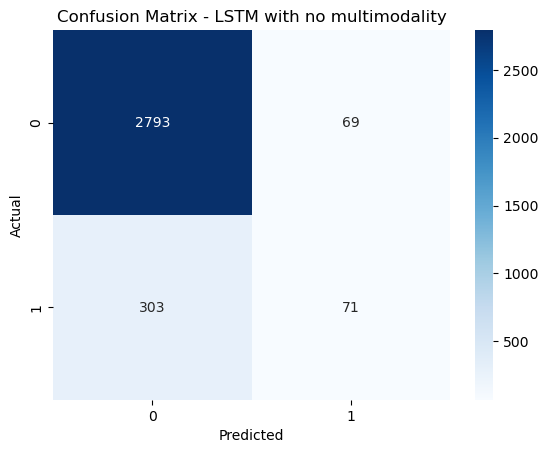

In [64]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
# Predict the probabilities of the test data
y_pred_probs = model4.predict(padded_test_data)

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - LSTM with no multimodality')
plt.show()


102/102 [==============================] - 5s 44ms/step
AUC-ROC Score: 0.8032769425666206
Accuracy: 0.8881334981458591
Precision: 0.5357142857142857
Recall: 0.24064171122994651
F1 Score: 0.3321033210332104


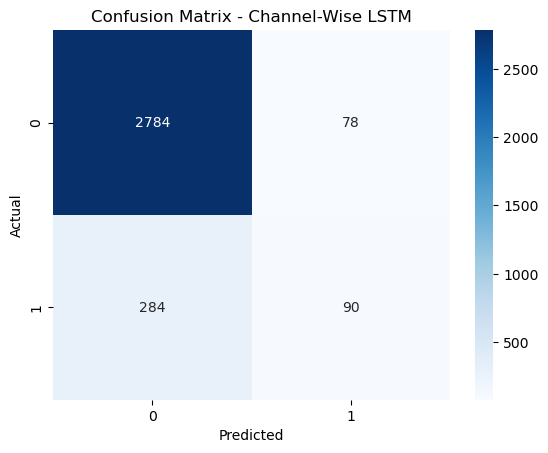

In [65]:
# Predict the probabilities of the test data
y_pred_probs = model3.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Channel-Wise LSTM')
plt.show()

102/102 [==============================] - 2s 18ms/step
AUC-ROC Score: 0.7631232786615694
Accuracy: 0.8686650185414091
Precision: 0.3967611336032389
Recall: 0.2620320855614973
F1 Score: 0.3156199677938808


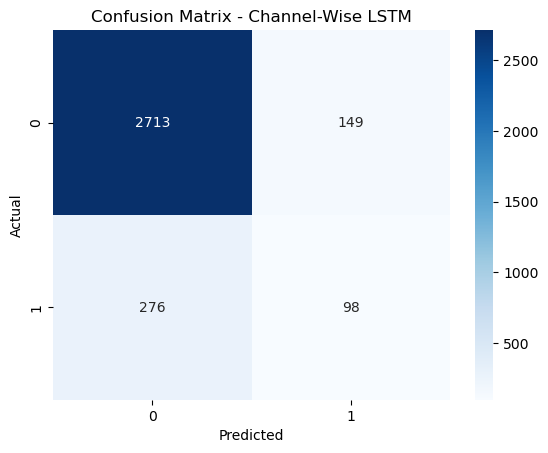

In [66]:
# Predict the probabilities of the test data
y_pred_probs = model1.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Channel-Wise LSTM')
plt.show()

In [252]:
# Initialize counters for missing values
missing_height = 0
missing_capillary_refill_rate = 0
missing_glass = 0
for i in range(train_reader.get_number_of_examples()):
    example = train_reader.read_example(i)
    data = example['X']
    header = example['header']

    # Find the indices of the "Height" and "Capillary refill rate" features
    height_index = header.index("Height")
    capillary_refill_rate_index = header.index("Capillary refill rate")
    glass_index = header.index("Glascow coma scale total")
    

    # Count the missing values in the "Height" and "Capillary refill rate" features
    missing_height += np.sum(data[:, height_index] == '')
    missing_capillary_refill_rate += np.sum(data[:, capillary_refill_rate_index] == '')
    missing_glass += np.sum(data[:, glass_index] == '')

# Print the results
print(f"Missing values in 'Height': {missing_height}")
print(f"Missing values in 'Capillary refill rate': {missing_capillary_refill_rate}")

Missing values in 'Height': 1191916
Missing values in 'Capillary refill rate': 1192160


In [253]:
print(f"Missing values in 'Height': {missing_glass}")

Missing values in 'Height': 1065338


In [73]:
get_static_features(train_reader, 0)

[48.68239345509893, nan, 59.0, 2, 4, 'carevue', 'CSRU', 'EMERGENCY']

In [232]:
normalized_data[1]

array([ 8.0000001e-01,  0.0000000e+00,  2.7477181e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -1.5064976e+00,  0.0000000e+00,
       -1.2043160e+00,  1.5169274e+00,  0.0000000e+00,  1.9379996e+00,
        1.0181508e+00,  2.3077612e+00,  1.1484470e+00, -3.3087292e+00,
       -1.3653717e+00,  7.0963616e+22], dtype=float32)

In [235]:
padded_train_data[0][1]

array([ 8.0000001e-01,  0.0000000e+00,  2.7477181e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -1.5064976e+00,  0.0000000e+00,
       -1.2043160e+00,  1.5169274e+00,  0.0000000e+00,  1.9379996e+00,
        1.0181508e+00,  2.3077612e+00,  1.1484470e+00, -3.3087292e+00,
       -1.3653717e+00,  7.0292345e+28], dtype=float32)

In [197]:
discretized_data[0]

array([  0.    ,   0.    ,  52.    ,   0.    ,   5.    ,   5.    ,
        15.    ,  11.    ,   0.    ,  76.    ,   0.    ,  76.    ,
        97.    ,  26.    , 124.    ,  37.7778,  78.7   ,   0.    ],
      dtype=float32)

In [238]:
train_data_static

array([[-1.40197305,         nan, -0.93149507,  2.        ,  4.        ,
         1.        ,  5.        ,  1.        ],
       [ 1.21199772,         nan,  0.04610556,  1.        ,  4.        ,
         1.        ,  3.        ,  1.        ],
       [-0.22712943,         nan, -1.19946693,  1.        ,  4.        ,
         1.        ,  4.        ,  1.        ],
       [ 1.33234443,  0.70710678, -0.49195369,  1.        ,  2.        ,
         2.        ,  3.        ,  1.        ],
       [-0.71999705,         nan,  2.04596922,  2.        ,  0.        ,
         1.        ,  4.        ,  1.        ],
       [ 0.43449986,         nan, -0.36577685,  2.        ,  4.        ,
         2.        ,  3.        ,  1.        ],
       [-1.57476344,         nan,         nan,  2.        ,  4.        ,
         1.        ,  1.        ,  1.        ],
       [-0.15553271,  0.70710678,  1.31553772,  1.        ,  4.        ,
         2.        ,  1.        ,  1.        ],
       [-0.12867025,         nan